In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Load the Sequential model
from tensorflow.keras.models import Sequential


In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [9]:
model = Sequential()

# First convolutional block
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2, strides=2))

# Second convolutional block
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.25))  ## drop 25% neurons (stop)

# Third convolutional block
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# Fourth convolutional block
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=32, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax'))

model.compile(
    optimizer=  Adam() ,  # 'adam'
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

In [10]:
model.compile(
    optimizer=  Adam() ,  # 'adam'
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

In [11]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 200ms/step - accuracy: 0.2329 - loss: 2.0007 - val_accuracy: 0.4937 - val_loss: 1.3745
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 156s 199ms/step - accuracy: 0.4884 - loss: 1.4011 - val_accuracy: 0.5798 - val_loss: 1.1609
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 198ms/step - accuracy: 0.5806 - loss: 1.1794 - val_accuracy: 0.6615 - val_loss: 0.9621
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 198ms/step - accuracy: 0.6400 - loss: 1.0296 - val_accuracy: 0.6758 - val_loss: 0.9152
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 199ms/step - accuracy: 0.6828 - loss: 0.9317 - val_accuracy: 0.7106 - val_loss: 0.8283


In [12]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


313/313 - 8s - 26ms/step - accuracy: 0.7106 - loss: 0.8283
Test accuracy: 0.7106, Test loss: 0.8283


In [13]:
# Load the pre-trained MobileNetV2 model without the top classification layers
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the MobileNetV2 base layers (these won't be trained)
mobilenet_base.trainable = False

# Now you can add this MobileNetV2 base to your Sequential or other model architecture

/tmp/ipykernel_30/3477430641.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Build the Sequential model
model = Sequential()

# Add the pre-trained MobileNetV2 base model (as feature extractor)
model.add(mobilenet_base)

# Add a pooling layer to reduce the output from MobileNetV2
model.add(GlobalAveragePooling2D())

# Add Dense layers for the new classification task
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64, activation='relu'))

# Output layer for binary classification (adjust units and activation for your specific task)
model.add(Dense(units=10, activation='softmax'))  # For binary classification (adjust if needed)

In [15]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history2 = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.3681 - loss: 1.7385 - val_accuracy: 0.3580 - val_loss: 1.7801
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.3711 - loss: 1.7329 - val_accuracy: 0.3592 - val_loss: 1.7765
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.3682 - loss: 1.7197 - val_accuracy: 0.3579 - val_loss: 1.7789
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.3730 - loss: 1.7155 - val_accuracy: 0.3578 - val_loss: 1.7777
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.3765 - loss: 1.7196 - val_accuracy: 0.3640 - val_loss: 1.7764


In [18]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

313/313 - 8s - 24ms/step - accuracy: 0.3640 - loss: 1.7764
Test accuracy: 0.3640, Test loss: 1.7764


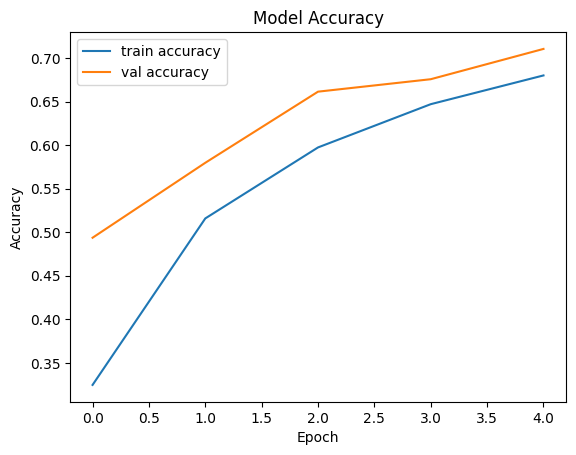

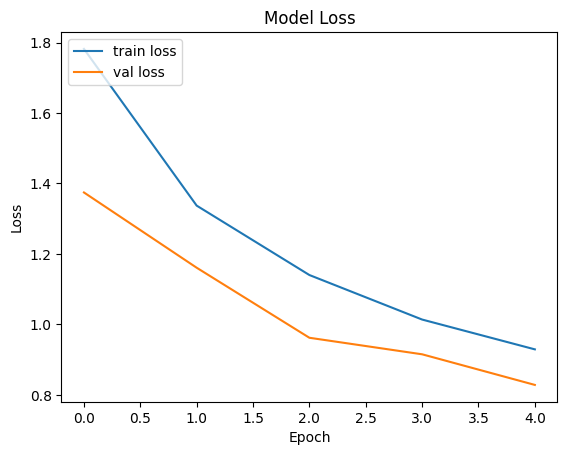

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


# Fine-tuning the Model (Optional)

In [28]:
# Unfreeze the base model for fine-tuning
mobilenet_base.trainable = True
# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model on the dataset
history_finetune = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 209s 222ms/step - accuracy: 0.1348 - loss: 18.9975 - val_accuracy: 0.1266 - val_loss: 15.8279
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 187s 239ms/step - accuracy: 0.1806 - loss: 5.9246 - val_accuracy: 0.1278 - val_loss: 2.8199
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 182s 232ms/step - accuracy: 0.1915 - loss: 3.4492 - val_accuracy: 0.1488 - val_loss: 2.4847
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 178s 227ms/step - accuracy: 0.2043 - loss: 2.7571 - val_accuracy: 0.1765 - val_loss: 2.3446
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 174s 223ms/step - accuracy: 0.2194 - loss: 2.4051 - val_accuracy: 0.2193 - val_loss: 2.1873


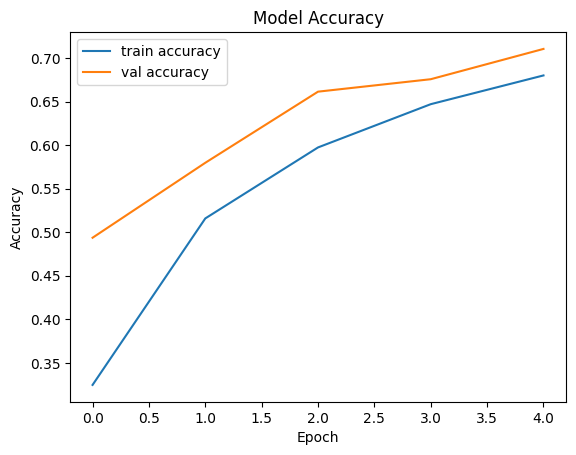

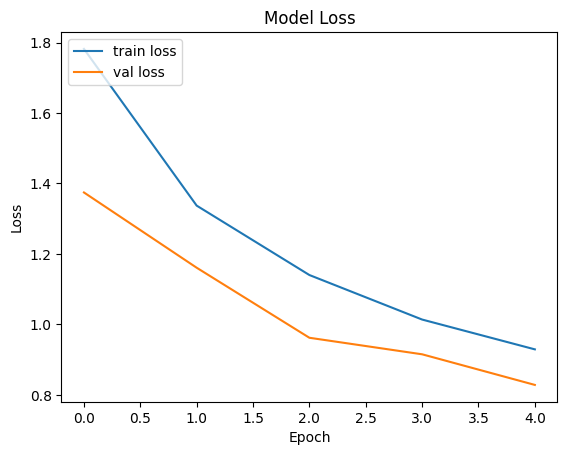

In [29]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
